# **Load**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install foolbox==1.8.0

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable
import torch.optim as optim
import time
import os
import argparse
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.init as init
import foolbox
from scipy import ndimage
import tensorflow as tf
import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/GTSRB')
from amd.amd import AMD

EPOCH = 50   
pre_epoch = 0  
BATCH_SIZE = 128     

transform_train = transforms.Compose([
    transforms.Resize([32,32]),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize([32,32]),
    transforms.ToTensor(),
])

data_dir="/content/drive/My Drive/Colab Notebooks/GTSRB/images"
# data_dir= "/content/drive/My Drive/Colab Notebooks/GTSRB/Day27_resnet_train"
Testing_datasets = datasets.ImageFolder(root=os.path.join(data_dir,"Testing"),transform=transform_test)      
testloader = torch.utils.data.DataLoader(dataset=Testing_datasets,batch_size=1,shuffle=True)

# **Resnet**

In [0]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    def resnet_train(self,device,accuracy):
        LR = 0.1        #学习率
        initepoch = 0
        # 定义损失函数和优化方式
        optimizer = optim.SGD(self.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）

        path = "/content/drive/My Drive/Colab Notebooks/ADP/model/Resnet/ResNet50_0.tar"
        best_acc = 85  #2 初始化best test accuracy
        print("Start Training, Resnet-20!")  # 定义遍历数据集的次数
        if os.path.exists(path) is not True:
            criterion = nn.CrossEntropyLoss()  #损失函数为交叉熵，多用于多分类问题
            optimizer = optim.SGD(self.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）
        else:
            checkpoint = torch.load(path)
            self.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            initepoch = checkpoint['epoch']
            criterion = checkpoint['criterion']

        for epoch in range(initepoch, EPOCH):
            timestart = time.time()
            print('\nEpoch: %d' % (epoch + 1))
            net.train()
            sum_loss = 0.0
            correct = 0.0
            total = 0.0
            if epoch>=5:
                LR = 0.01
                optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）

            if epoch>=15:
                LR = 0.05
                optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）
                
            if epoch>=25:
                LR = 0.001
                optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）

            if epoch>=35:
                LR = 0.0001
                optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）

            print("进入数据")
            for i, data in enumerate(trainloader, 0):
                # 准备数据
                length = len(trainloader)
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                # print("train_labels")
                # print(labels)
                optimizer.zero_grad()
                # forward + backward
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                sum_loss += loss.item()
            torch.save({'epoch':epoch,
                                    'model_state_dict':net.state_dict(),
                                    'optimizer_state_dict':optimizer.state_dict(),
                                    'criterion':criterion
                                    },path)
            print('epoch %d cost %3f sec' %(epoch,time.time()-timestart))
            print("Waiting Test!")
            with torch.no_grad():
              correct = 0
              total = 0
              for data in testloader:
                  net.eval()
                  images, labels = data
                  images, labels = images.to(device), labels.to(device)
                  outputs = net(images)
                  # 取得分最高的那个类 (outputs.data的索引号)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum()
            accuracy.append(100.0 * correct / total)
            print(accuracy)
            print('测试分类准确率为：%.3f%%' % (100. * correct / total))
            print('Saving model......')
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

# **foolbox_Resnet50**

cuda:0
ori image


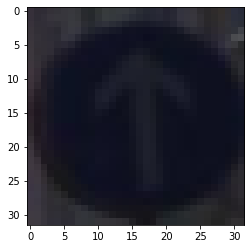

ack image


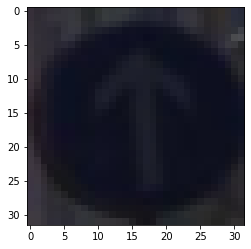

AMD image


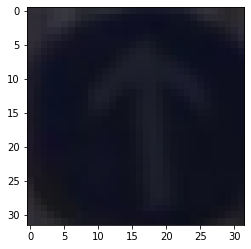

ori image


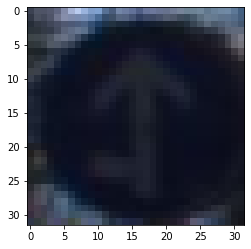

ack image


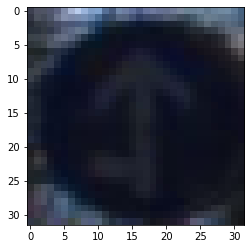

AMD image


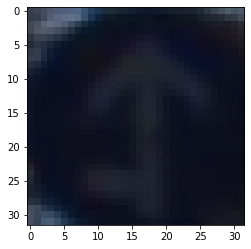

ori image


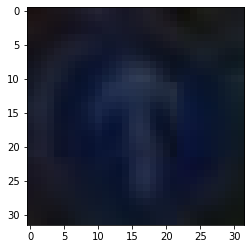

ack image


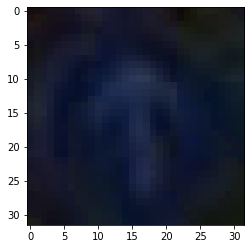

AMD image


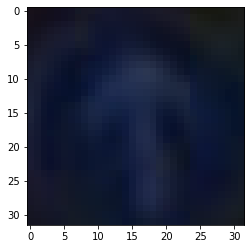

ori image


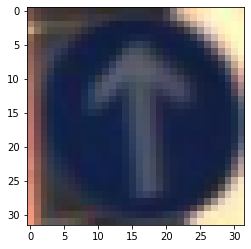

ack image


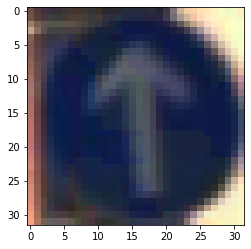

AMD image


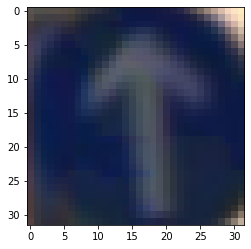

ori image


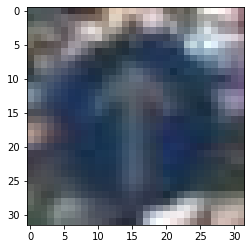

ack image


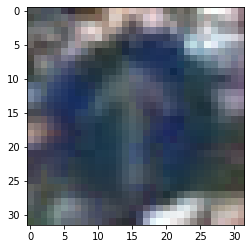

AMD image


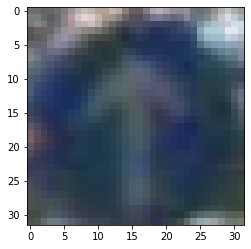

ori image


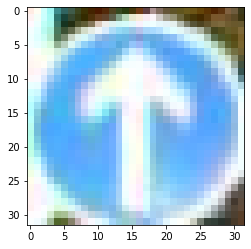

ack image


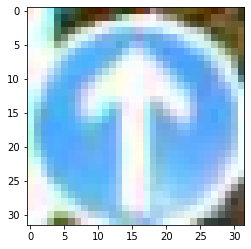

AMD image


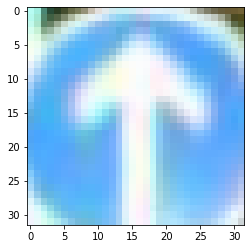

ori image


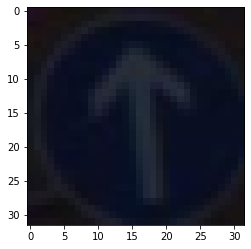

ack image


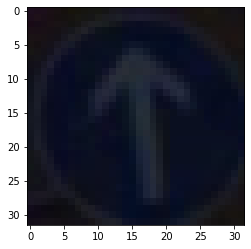

AMD image


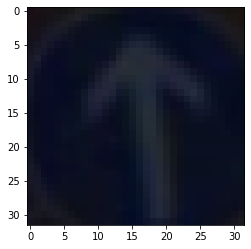

ori image


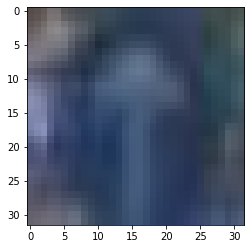

ack image


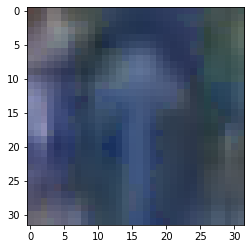

AMD image


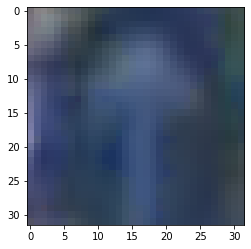

ori image


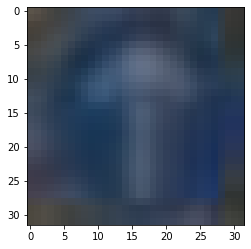

ack image


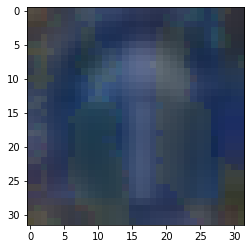

AMD image


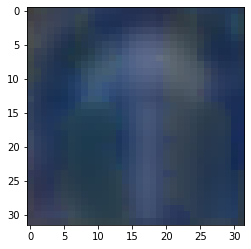

label:  4
Accuracy of original image: 0.900
Accuracy of attack sample: 0.100
Accuracy of AMD: 0.700


KeyboardInterrupt: ignored

In [10]:
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model_ResNet50 = ResNet50()
model_ResNet50 = model_ResNet50.to(device).eval()
path='/content/drive/My Drive/Colab Notebooks/GTSRB/model/ResNet50_1.tar'
# path='/content/drive/My Drive/Colab Notebooks/GTSRB/model/Resnet_27/ResNet50_1.tar'
checkpoint = torch.load(path,map_location=device)
model_ResNet50.load_state_dict(checkpoint['model_state_dict'])

fmodel_ResNet50 = foolbox.models.PyTorchModel(model_ResNet50, bounds=(0, 1), num_classes=10, preprocessing=(0, 1))

count=10 #test images
total=0 #total images
num1=0 #fmodel correct 
num2=0 #attack success
num4=0 #ABDM

label_number=4
original_rate=[]
adv_rate=[]
abdm_rate=[]
for batch_idx, data in enumerate(testloader):
  image, label = data
  image=image.squeeze(0).data.numpy()
  label = label.numpy()[0]
  if(total==count): 
    print("label: ",label_number)
    print("Accuracy of original image: %.3f"%(num1/count))
    print("Accuracy of attack sample: %.3f"%(1-num2/count)) 
    print("Accuracy of AMD: %.3f" %(num4/count))
    print("=======================================")
    original_rate.append(num1/count)
    adv_rate.append(1-num2/count)
    abdm_rate.append(num4/count)
    num4 = 0
    num1 = 0
    num2 = 0
    total = 0
    label_number = label_number + 1
  # time_start = time.time()
  # fmodel_ResNet50.predictions(image)
  # time_end = time.time()
  # print('Time cost = %fs' % (time_end - time_start))  
  if(label==label_number and total<count and label_number<=4):
    total+=1 
    if(np.argmax(fmodel_ResNet50.predictions(image))==label): 
      num1+=1
      attack_ResNet50=foolbox.attacks.FGSM(fmodel_ResNet50,distance=foolbox.distances.L0) 
      adversarial_ResNet50=attack_ResNet50(input_or_adv=image,label=label,unpack=False) 
      adv_ResNet50=adversarial_ResNet50.image
      if(adv_ResNet50 is not None):
        num2+=1 

        ori = image
        ori = np.transpose(ori, (1,2,0))
        print("ori image")
        plt.imshow(ori)
        plt.show()

        adv_ResNet50_class = np.argmax(fmodel_ResNet50.predictions(adv_ResNet50))  

        ack = adv_ResNet50 #(3, 32, 32)
        ack = np.transpose(ack, (1,2,0))
        print("ack image")
        plt.imshow(ack)
        plt.show()
        #ABDM
        im = adv_ResNet50
        transform = transforms.Compose([transforms.ToTensor()])
        im = transform(im).numpy()
        im = transform(im).numpy()
        im = im.reshape(1, 32, 32, 3)
        im = im.astype('float32')
        out_size = (32, 32)
        batch = np.append(im, im, axis=0)
        batch = np.append(batch, im, axis=0)
        num_batch = 3 
        x = tf.placeholder(tf.float32, [None, 32, 32, 3])
        x = tf.cast(batch, 'float32')
        with tf.variable_scope('spatial_transformer_0'):
            n_fc = 6
            w_fc1 = tf.Variable(tf.Variable(tf.zeros([32 * 32 * 3, n_fc]), name='W_fc1'))
            initial = np.array([[0.85, 0, 0], [0, 0.85, 0]])
            initial = initial.astype('float32')
            initial = initial.flatten()  
            b_fc1 = tf.Variable(initial_value=initial, name='b_fc1')   
            h_fc1 = tf.matmul(tf.zeros([num_batch, 32 * 32 * 3]), w_fc1) + b_fc1
            h_trans = AMD(x, h_fc1, out_size)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        y = sess.run(h_trans, feed_dict={x: batch})
        abdmimg_temp=transform(y[0]).numpy()
        adv3_label = np.argmax(fmodel_ResNet50.predictions(abdmimg_temp))
        if(adv3_label==label):
          num4+=1
        abdmimg_temp=abdmimg_temp.reshape(1,3,32,32)
        imgFinal = abdmimg_temp
        imgFinal = imgFinal.squeeze(0) 
        imgFinal = np.transpose(imgFinal, (1,2,0)) 
        print("AMD image")
        plt.imshow(imgFinal)
        plt.show()
      else:    
        #ABDM
        im = image#
        transform = transforms.Compose([transforms.ToTensor()])
        im = transform(im).numpy()
        im = transform(im).numpy()
        im = im.reshape(1, 32, 32, 3)
        im = im.astype('float32')
        out_size = (32, 32)
        batch = np.append(im, im, axis=0)
        batch = np.append(batch, im, axis=0)
        num_batch = 3 
        x = tf.placeholder(tf.float32, [None, 32, 32, 3])
        x = tf.cast(batch, 'float32')
        with tf.variable_scope('spatial_transformer_0'):
            n_fc = 6
            w_fc1 = tf.Variable(tf.Variable(tf.zeros([32 * 32 * 3, n_fc]), name='W_fc1'))
            initial = np.array([[0.85, 0, 0], [0, 0.85, 0]])
            initial = initial.astype('float32')
            initial = initial.flatten()  
            b_fc1 = tf.Variable(initial_value=initial, name='b_fc1')   
            h_fc1 = tf.matmul(tf.zeros([num_batch, 32 * 32 * 3]), w_fc1) + b_fc1
            h_trans = AMD(x, h_fc1, out_size)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        y = sess.run(h_trans, feed_dict={x: batch})
        abdmimg_temp=transform(y[0]).numpy()
        adv3_label = np.argmax(fmodel_ResNet50.predictions(abdmimg_temp))
        if(adv3_label==label):
          num4+=1

print(original_rate)
print(adv_rate)
print(abdm_rate)